# Venomous/non-venomous Snake Classification (EfficientNet-B0)

In [1]:
import os

os.chdir('..')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch

from src.core import models, metrics, training, data, loss_functions
from src.special import calibration
from src.utils import nb_setup, io

PREDICTIONS_DIR = 'predictions/'
DATA_DIR = 'data/snake_clef2021_dataset/'
TRAIN_SET_DIR = 'train'

MODEL_ARCH = 'efficientnet_b0'
MODEL_NAME = 'baselines/clef2021_efficientnet_b0_ce_11-29-2021_16-52-38'

PRED_FILE = PREDICTIONS_DIR + 'snake_full_efficientnet_b0_pred.npy'
TARG_FILE = PREDICTIONS_DIR + 'snake_full_targ.npy'

SEED = 42

nb_setup.init()
nb_setup.set_random_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}')

Device: cpu


## Load the Data

In [3]:
# load metadata
train_df = pd.read_csv(DATA_DIR + 'SnakeCLEF2021_train_metadata_cleaned.csv')
test_df = pd.read_csv(DATA_DIR + 'SnakeCLEF2021_test_metadata_cleaned.csv')
classes = np.unique(train_df['binomial'])
no_classes = len(classes)
print(f'No classes: {no_classes}')

# load medical importance map
mi_map = pd.read_csv(DATA_DIR + 'species_medical_importance.csv')
mi_map = mi_map.rename(columns={'species': 'binomial'})
mi_map['mivs'] = mi_map['mivs'].replace({0: 'Non-venomous', 1: 'Venomous'})

no_classes_overlap = mi_map['binomial'].str.lower().isin(pd.Series(classes).str.lower()).sum()
assert no_classes_overlap == no_classes

No classes: 770


In [4]:
mi_map

,binomial,genus,family,mivs
0,Acanthophis antarcticus,Acanthophis,Elapidae,Venomous
1,Acanthophis cryptamydros,Acanthophis,Elapidae,Venomous
2,Acanthophis hawkei,Acanthophis,Elapidae,Venomous
3,Acanthophis laevis,Acanthophis,Elapidae,Venomous
4,Acanthophis praelongus,Acanthophis,Elapidae,Venomous
...,...,...,...,...
3891,Sinonatrix aequifasciata,Sinonatrix,Colubridae,Non-venomous
3892,Sinonatrix annularis,Sinonatrix,Colubridae,Non-venomous
3893,Sinonatrix percarinata,Sinonatrix,Colubridae,Non-venomous
3894,Xenochrophis flavipunctatus,Xenochrophis,Colubridae,Non-venomous


In [5]:
# merge information about venomous snakes
train_df = train_df.merge(mi_map, 'left', on=['family', 'genus', 'binomial'], validate='many_to_one')
train_df['mivs'] = train_df['mivs'].fillna('N/A')

In [6]:
species = np.unique(test_df['binomial'])
countries = np.unique(test_df['country'].fillna('unknown'))

# create country-species weight for adjusting predictions
country_map_df = pd.read_csv(DATA_DIR + 'species_to_country_mapping.csv', index_col=0)
country_lut = io.read_json(DATA_DIR + 'country_lut.json')
country_weights_adj = metrics.clean_country_map(
    country_map_df.rename(columns=country_lut), species, countries, missing_val=1)

## Run Inference

In [7]:
# create model
model = models.get_model(MODEL_ARCH, no_classes, pretrained=True)
training.load_model(model, MODEL_NAME, path=DATA_DIR + 'models')
assert np.all([param.requires_grad for param in model.parameters()])

model_config = model.pretrained_config
batch_size = 128

# create transforms and dataloaders
_, valid_tfms = data.get_transforms(
    size=model_config['input_size'], mean=model_config['image_mean'],
    std=model_config['image_std'])
testloader = data.get_dataloader(
    test_df, img_path_col='image_path', label_col='binomial',
    path=DATA_DIR + TRAIN_SET_DIR, transforms=valid_tfms,
    batch_size=batch_size, shuffle=False, num_workers=4)

In [8]:
def predict_cached(model, testloader, *, pred_filename, targ_filename):
    import os

    if os.path.isfile(pred_filename) and os.path.isfile(targ_filename):
        pred = np.load(pred_filename)
        targ = np.load(targ_filename)
    else:
        pred, targ, _ = training.predict(model, testloader)
        np.save(pred_filename, pred)
        np.save(targ_filename, targ)
    return pred, targ

In [9]:
# create predictions
logits, targ = predict_cached(
    model, testloader, pred_filename=PRED_FILE, targ_filename=TARG_FILE)

In [10]:
from sklearn.model_selection import train_test_split

test_ids, valid_ids = train_test_split(np.arange(len(test_df)), test_size=2000, random_state=42)  # , stratify=test_df['binomial']
print(f'Validation set length: {len(valid_ids):,d}')
print(f'Test set length: {len(test_ids):,d}')

Validation set length: 2,000
Test set length: 24,227


In [11]:
def softmax(x, temperature=None):
    if temperature is not None:
        x = x / temperature
    e = np.exp(x - x.max())  # X.max() makes function exp more stable
    return e / e.sum(axis=1, keepdims=True)


# calibrate predictions
temperature = calibration.tune_temperature(logits=logits[valid_ids], targs=targ[valid_ids])

# apply softmax function with temperature scaling
pred = softmax(logits[test_ids])
calib_pred = softmax(logits[test_ids], temperature=temperature)

targ = targ[test_ids]
test_df = test_df.iloc[test_ids]

Before temperature - NLL: -22.648
Optimal temperature: 1.167
After temperature - NLL: -19.402


In [12]:
# adjust predictions using country
_df = test_df.copy()
_df['country'] = _df['country'].fillna('unknown')
bin_map = country_weights_adj.loc[:, _df['country']].values.T
pred = pred * bin_map
calib_pred = calib_pred * bin_map

## Compare Methods 1-3 for Creating Venomous/non-venomous Decision

The task is to make decision -> Venomous vs. Non-venomous (i.e. should we apply anti-venom or not)
* Method 1 - decision based on the argmax prediction
* Method 2 - decision based on the aggregation of predictions for Venomous and Non-venomous snakes
* Method 3 - decision based on the weighted aggregation of predictions

Methods 1-3 (TS) include classifier callibration.

In [13]:
def create_targ_df(targ, mi_map, labels, index):
    from sklearn.preprocessing import OneHotEncoder

    onehot = OneHotEncoder()
    targ_onehot = onehot.fit_transform(targ.reshape(-1, 1)).toarray()
    targ_df = pd.DataFrame(targ_onehot, columns=labels, index=index)

    # create multicolumn with medical importance information
    mi_dict = mi_map.set_index('binomial')['mivs'].to_dict()
    columns = [(mi_dict.get(col, 'N/A'), col) for col in targ_df.columns]
    targ_df.columns = pd.MultiIndex.from_tuples(columns)

    return targ_df


def create_pred_df(pred, mi_map, labels, index):
    pred_df = pd.DataFrame(pred, columns=labels, index=index)

    # create multicolumn with medical importance information
    mi_dict = mi_map.set_index('binomial')['mivs'].to_dict()
    columns = [(mi_dict.get(col, 'N/A'), col) for col in pred_df.columns]
    pred_df.columns = pd.MultiIndex.from_tuples(columns)

    return pred_df


targ_df = create_targ_df(targ, mi_map, labels=testloader.dataset.labels, index=test_df.index)
pred_df = create_pred_df(pred, mi_map, labels=testloader.dataset.labels, index=test_df.index)
calib_pred_df = create_pred_df(calib_pred, mi_map, labels=testloader.dataset.labels, index=test_df.index)

In [14]:
def agg_mi(df):
    columns = list(df.columns.levels[0])
    out = []
    for col in columns:
        out.append(df[col].sum(1))
    out = pd.concat(out, axis=1)
    out.columns = columns
    return out


mi_pred_df = agg_mi(pred_df)
mi_targ_df = agg_mi(targ_df)
calib_mi_pred_df = agg_mi(calib_pred_df)

In [15]:
# target predictions
target_prediction = mi_targ_df.idxmax(1)

# Method 1 - argmax prediction
argmax_prediction = pred_df.idxmax(1).str[0]

# Method 2 - argmax of predictions sum
sum_prediction = mi_pred_df.idxmax(1)

# Method 3 - weighted Method 2
weighted_prediction = (mi_pred_df * [0.1**2, 1.0]).idxmax(1)

# Method 1 (TS) - calibrated argmax prediction
calib_argmax_prediction = calib_pred_df.idxmax(1).str[0]

# Method 2 (TS) - calibrated argmax of predictions sum
calib_sum_prediction = calib_mi_pred_df.idxmax(1)

# Method 3 (TS) - calibrated weighted Method2'
calib_weighted_prediction = (calib_mi_pred_df * [0.1**2, 1.0]).idxmax(1)

In [16]:
def classification_scores(targ, pred, labels):
    from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                                 f1_score)
    scores = {
        'accuracy': accuracy_score(targ, pred),
        'precision': precision_score(targ, pred, labels=labels, pos_label=labels[1]),
        'recall': recall_score(targ, pred, labels=labels, pos_label=labels[1]),
        'f1-score': f1_score(targ, pred, labels=labels, pos_label=labels[1])}
    return scores


def get_cm(targ, pred, labels): 
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(targ, pred, labels=labels)
    cm = pd.DataFrame(cm, columns=labels, index=labels)
    cm = cm.rename(columns=lambda x: f'Predicted - {x}', index=lambda x: f'Target - {x}')
    cm = cm.loc[::-1, ::-1]

    scores = classification_scores(targ, pred, labels)
    print(f'accuracy: {scores["accuracy"]:.3f}')
    print(f'precision: {scores["precision"]:.3f}')
    print(f'recall: {scores["recall"]:.3f}')
    print(f'f1-score: {scores["f1-score"]:.3f}')

    return cm, scores

### Method 1

In [17]:
cm_1, scores_1 = get_cm(target_prediction, argmax_prediction, labels=mi_targ_df.columns)
cm_1

accuracy: 0.986
precision: 0.968
recall: 0.967
f1-score: 0.967


,Predicted - Venomous,Predicted - Non-venomous
Target - Venomous,4934,171
Target - Non-venomous,162,18960


### Method 2

In [18]:
cm_2, scores_2 = get_cm(target_prediction, sum_prediction, labels=mi_targ_df.columns)
cm_2

accuracy: 0.988
precision: 0.978
recall: 0.966
f1-score: 0.972


,Predicted - Venomous,Predicted - Non-venomous
Target - Venomous,4930,175
Target - Non-venomous,113,19009


### Method 3

In [19]:
cm_3, scores_3 = get_cm(target_prediction, weighted_prediction, labels=mi_targ_df.columns)
cm_3

accuracy: 0.964
precision: 0.859
recall: 0.992
f1-score: 0.921


,Predicted - Venomous,Predicted - Non-venomous
Target - Venomous,5064,41
Target - Non-venomous,832,18290


### Method 1 (TS)

In [20]:
calib_cm_1, calib_scores_1 = get_cm(target_prediction, calib_argmax_prediction, labels=mi_targ_df.columns)
calib_cm_1

accuracy: 0.986
precision: 0.968
recall: 0.967
f1-score: 0.967


,Predicted - Venomous,Predicted - Non-venomous
Target - Venomous,4934,171
Target - Non-venomous,162,18960


### Method 2 (TS)

In [21]:
calib_cm_2, calib_scores_2 = get_cm(target_prediction, calib_sum_prediction, labels=mi_targ_df.columns)
calib_cm_2

accuracy: 0.988
precision: 0.979
recall: 0.966
f1-score: 0.972


,Predicted - Venomous,Predicted - Non-venomous
Target - Venomous,4931,174
Target - Non-venomous,107,19015


### Method 3 (TS)

In [22]:
calib_cm_3, calib_scores_3 = get_cm(target_prediction, calib_weighted_prediction, labels=mi_targ_df.columns)
calib_cm_3

accuracy: 0.954
precision: 0.825
recall: 0.993
f1-score: 0.901


,Predicted - Venomous,Predicted - Non-venomous
Target - Venomous,5067,38
Target - Non-venomous,1072,18050


## Summarize the Results

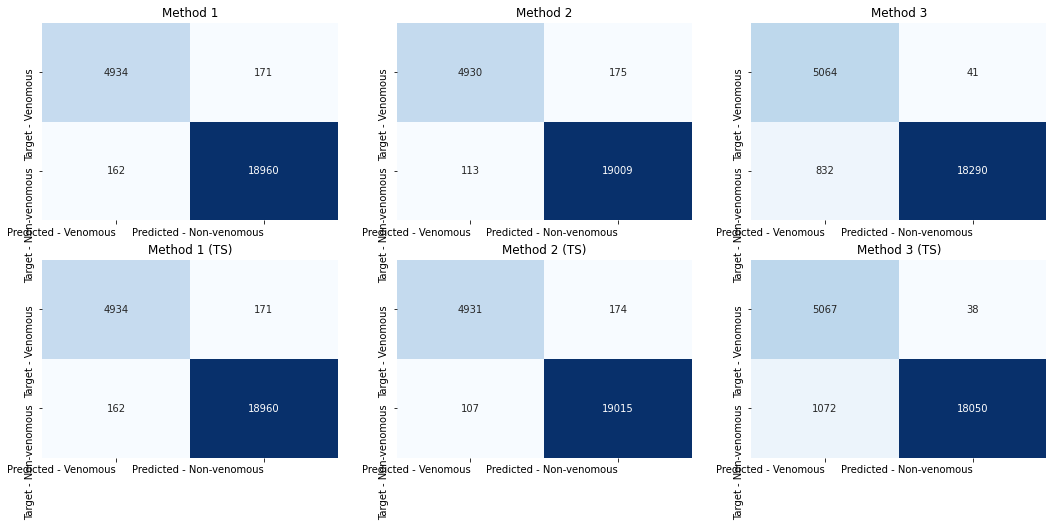

In [23]:
import seaborn as sns

from src.utils import visualization as viz


def heatmap(df, title=None, ax=None):
    ax = sns.heatmap(df, cmap='Blues', annot=True, fmt='d', cbar=False, ax=ax)
    if title is not None:
        ax.set(title=title)
    return ax

fig, axs = viz.create_fig(ncols=3, nrows=2, colsize=6, rowsize=4)
cms = {
    'Method 1': cm_1,
    'Method 2': cm_2,
    'Method 3': cm_3,
    'Method 1 (TS)': calib_cm_1,
    'Method 2 (TS)': calib_cm_2,
    'Method 3 (TS)': calib_cm_3}
for ax, (title, _cm) in zip(axs, cms.items()):
    heatmap(_cm, title, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='right')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=90, ha='right')
plt.show()

In [24]:
{k: v.values.tolist() for k, v in cms.items()}

{'Method 1': [[4934, 171], [162, 18960]],
 'Method 2': [[4930, 175], [113, 19009]],
 'Method 3': [[5064, 41], [832, 18290]],
 'Method 1 (TS)': [[4934, 171], [162, 18960]],
 'Method 2 (TS)': [[4931, 174], [107, 19015]],
 'Method 3 (TS)': [[5067, 38], [1072, 18050]]}

In [25]:
scores = {
    'Method 1': scores_1,
    'Method 2': scores_2,
    'Method 3': scores_3,
    'Method 1 (TS)': calib_scores_1,
    'Method 2 (TS)': calib_scores_2,
    'Method 3 (TS)': calib_scores_3}
pd.DataFrame(scores).T.round(3) * 100

,accuracy,precision,recall,f1-score
Method 1,98.6,96.8,96.7,96.7
Method 2,98.8,97.8,96.6,97.2
Method 3,96.4,85.9,99.2,92.1
Method 1 (TS),98.6,96.8,96.7,96.7
Method 2 (TS),98.8,97.9,96.6,97.2
Method 3 (TS),95.4,82.5,99.3,90.1
